In [20]:
%matplotlib inline
from sklearn.neighbors import NearestNeighbors
from matplotlib.pyplot import imshow
import requests
import random
import os
import base64
from sklearn.decomposition import TruncatedSVD
from keras.models import Model
from hashlib import md5
import pickle
try:
    from urllib import unquote
except ImportError:
    from urllib.parse import unquote
from PIL import Image
import requests
try:
    from io import BytesIO
except ImportError:
    from StringIO import StringIO as BytesIO
from IPython.display import HTML, Image as iPythonImage, display
import numpy as np
from tqdm import tqdm
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image

In [2]:
query = """SELECT DISTINCT ?pic
WHERE
{
    ?item wdt:P31 ?class . 
    ?class wdt:P18 ?pic
}"""

In [3]:
url = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql'
data = requests.get(url, params={'query': query, 'format': 'json'}).json()


In [4]:
images = [x['pic']['value'] for x in data['results']['bindings']]
len(images), random.sample(images, 10)

(7677,
 ['http://commons.wikimedia.org/wiki/Special:FilePath/God%20kv%C3%A4ll%2C%20farbror%21%20H%C3%A4lsade%20pojken.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/PS3%20Wireless%20Keypad.png',
  'http://commons.wikimedia.org/wiki/Special:FilePath/KandaMyojin8834.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Flock%20of%20sheep.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Oecophorinae.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/IrishWhiskey.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Stagnone%20di%20Marsala.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Bali%20panorama.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Koekjestrommel%20open.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Purple%20smoke%20grenade.jpg'])

In [5]:
IMAGE_DIR = 'wp_images'
if not os.path.isdir(IMAGE_DIR):
    os.mkdir(IMAGE_DIR)

In [6]:
def center_crop_resize(img, new_size):
    w, h = img.size
    s = min(w, h)
    y = (h - s) // 2
    x = (w - s) // 2
    img = img.crop((x, y, s, s))
    return img.resize((new_size, new_size))


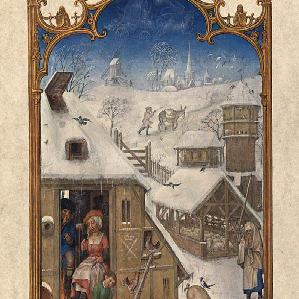

In [7]:
def fetch_image(image_cache, image_url):
    image_name = image_url.rsplit('/', 1)[-1]
    local_name = image_name.rsplit('.', 1)[0] + '.jpg'
    local_path = os.path.join(image_cache, local_name)
    if os.path.isfile(local_path):
        img = Image.open(local_path)
        img.load()
        return center_crop_resize(img, 299)
    image_name = unquote(image_name).replace(' ', '_')
    m = md5()
    m.update(image_name.encode('utf8'))
    c = m.hexdigest()
    for prefix in 'http://upload.wikimedia.org/wikipedia/en', 'http://upload.wikimedia.org/wikipedia/commons':
        url = '/'.join((prefix, c[0], c[0:2], image_name))
        r = requests.get(url)
        if r.status_code != 404:
            try:
                img = Image.open(BytesIO(r.content))
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img.save(local_path)
                return center_crop_resize(img, 299)
            except IOError:
                pass
    return None

fetch_image(IMAGE_DIR, images[0])

In [14]:
valid_images = []
valid_image_names = []
for image_name in tqdm(images):
    img = fetch_image(IMAGE_DIR, image_name)
    if img:
        valid_images.append(img)
        valid_image_names.append(image_name)

  1%|          | 69/7677 [00:10<23:32,  5.38it/s]/home/douwe/proj/notebooks/venv3/lib/python3.5/site-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (196437984 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
  8%|▊         | 624/7677 [02:43<10:14, 11.48it/s]   /home/douwe/proj/notebooks/venv3/lib/python3.5/site-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (163328704 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
 14%|█▍        | 1099/7677 [03:38<06:19, 17.31it/s] /home/douwe/proj/notebooks/venv3/lib/python3.5/site-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (693930000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
 41%|████      | 3114/7677 [07:51<05:45, 13.19it/s]  /home/douwe/proj/notebooks/venv3/lib/python3.5/site-packages/PIL/Image.py:2371:

In [9]:
len(valid_images)

7328

In [15]:
base_model = InceptionV3(weights='imagenet', include_top=True)
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv2d_95 (Conv2D)               (None, 149, 149, 32)  864                                          
____________________________________________________________________________________________________
batch_normalization_95 (BatchNor (None, 149, 149, 32)  96                                           
____________________________________________________________________________________________________
activation_95 (Activation)       (None, 149, 149, 32)  0                                            
___________________________________________________________________________________________

In [16]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

In [17]:
def get_vector(img):
    if not type(img) == list:
        images = [img]
    else:
        images = img
    target_size = int(max(model.input.shape[1:]))
    images = [img.resize((target_size, target_size), Image.ANTIALIAS) for img in images]
    np_imgs = [image.img_to_array(img) for img in images]
    pre_processed = preprocess_input(np.asarray(np_imgs))
    return model.predict(pre_processed)

x = get_vector(valid_images[4])
x.shape

(1, 2048)

In [18]:
chunks = [get_vector(valid_images[i:i+256]) for i in range(0, len(valid_images), 256)]
vectors = np.concatenate(chunks)
vectors.shape

(7329, 2048)

In [19]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(vectors)

In [23]:
with open('data/image_similarity.pck', 'wb') as fout:
    pickle.dump({'nbrs': nbrs,
                 'image_names': valid_image_names,
                },
                fout
               )

In [24]:
cat = get_vector(Image.open('data/cat.jpg'))
distances, indices = nbrs.kneighbors(cat)

In [28]:
if True:
    images = [Image.open('data/cat.jpg')]
    target_size = int(max(model.input.shape[1:]))
    images = [img.resize((target_size, target_size), Image.ANTIALIAS) for img in images]
    np_imgs = [image.img_to_array(img) for img in images]
    pre_processed = preprocess_input(np.asarray(np_imgs))
    x = model.predict(pre_processed)


In [31]:
pre_processed

array([[[[-0.16862744, -0.34901959, -0.38823527],
         [-0.16862744, -0.32549018, -0.38039213],
         [-0.24705881, -0.372549  , -0.42745095],
         ..., 
         [ 0.27058828,  0.082353  , -0.01176471],
         [ 0.27843142,  0.09019613,  0.01176476],
         [ 0.22352946,  0.03529418, -0.03529412]],

        [[-0.18431371, -0.34901959, -0.38823527],
         [-0.19215685, -0.34117645, -0.39607841],
         [-0.23137254, -0.34901959, -0.41176468],
         ..., 
         [ 0.24705887,  0.05882359, -0.03529412],
         [ 0.24705887,  0.05882359, -0.02745098],
         [ 0.19215691,  0.01176476, -0.06666666]],

        [[-0.20784312, -0.35686272, -0.39607841],
         [-0.2235294 , -0.34901959, -0.41176468],
         [-0.23921567, -0.33333331, -0.40392154],
         ..., 
         [ 0.23137259,  0.05098045, -0.05882353],
         [ 0.23137259,  0.04313731, -0.05098039],
         [ 0.18431377, -0.00392157, -0.08235294]],

        ..., 
        [[-0.45098037, -0.47450978,


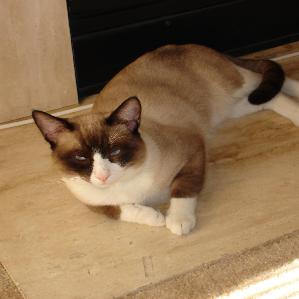
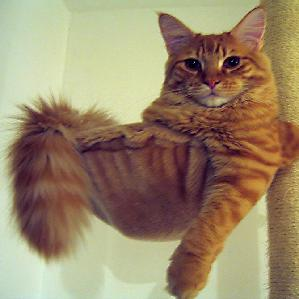
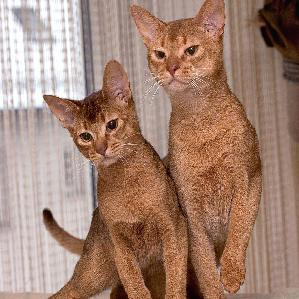
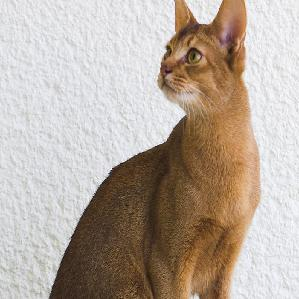
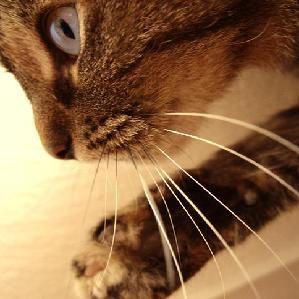
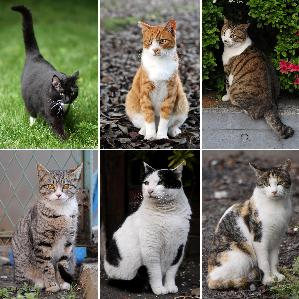
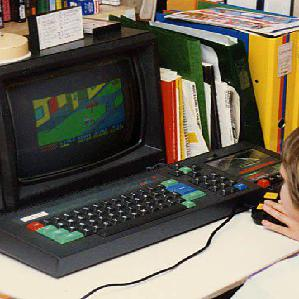
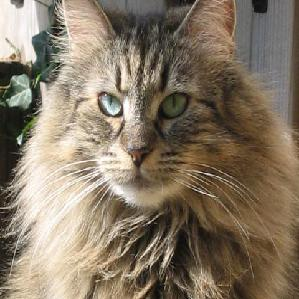
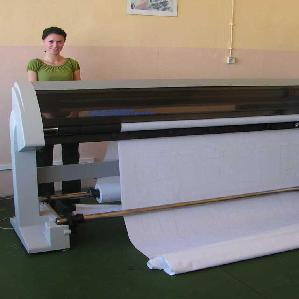
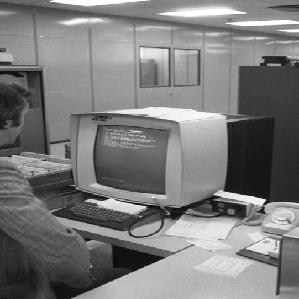

In [25]:
html = []
for idx, dist in zip(indices[0], distances[0]):
    b = BytesIO()
    valid_images[idx].save(b, format='jpeg')
    html.append("<img src='data:image/jpg;base64,{0}'/>".format(base64.b64encode(b.getvalue()).decode('utf-8')))
HTML(''.join(html))



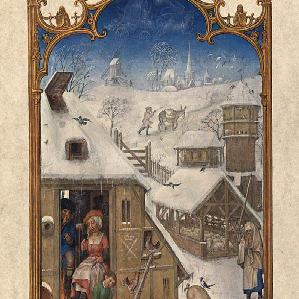

In [40]:
b = BytesIO()
valid_images[0].save(b, format='png')
HTML("<img src='data:image/png;base64,{0}'/>".format(base64.b64encode(b.getvalue()).decode('utf-8')))


In [51]:
nbrs64 = NearestNeighbors(n_neighbors=64, algorithm='ball_tree').fit(vectors)
distances64, indices64 = nbrs64.kneighbors(cat)

In [63]:
vectors64 = np.asarray([vectors[idx] for idx in indices64[0]])

svd = TruncatedSVD(n_components=2)
vectors64_transformed = svd.fit_transform(vectors64)
vectors64_transformed.shape

(64, 2)

In [77]:
img64 = Image.new('RGB', (8 * 75, 8 * 75), (180, 180, 180))

mins = np.min(vectors64_transformed, axis=0)
maxs = np.max(vectors64_transformed, axis=0)
xys = (vectors64_transformed - mins) / (maxs - mins)

for idx, (x, y) in zip(indices64[0], xys):
    x = int(x * 7) * 75
    y = int(y * 7) * 75
    img64.paste(valid_images[idx].resize((75, 75)), (x, y))

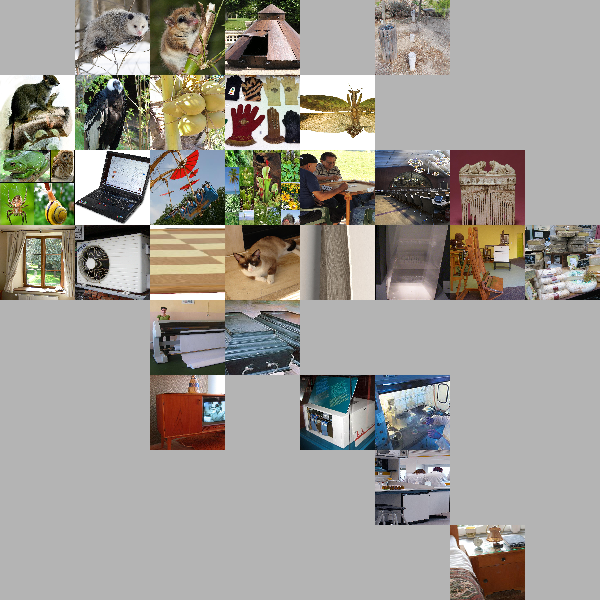

In [78]:
img64

In [ ]:
def simple_view(request):
    d = {}
    update_date(request, d)
    if request.FILES.get('painting'):
        data = request.FILES['painting'].read()
        files = {'file': data}
        reply = requests.post('http://localhost:5050', 
                              files=files).json()
        res = reply['results']
        if res:
            d['most_similar'] = res[0]['image_name']

    return render(request, 'template_path/template.html', d)